# Importing libraries

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pygam as gm
import copy as cp
from pyspi.calculator import Calculator
from matplotlib.ticker import (MultipleLocator)

## Common settings

In [2]:
nr_times = 154

dirdatain = '../data_GG/'
dirdataout = '../results_GG/'

species = {} # dictionary with the IDs of the species (as they change across networks)

print('Common settings done!')

Common settings done!


## Reading data

In [3]:
mydf = pd.read_csv(dirdatain+'pollen_GG_p.csv')
# mydf = pd.read_csv(dirdatain+'bsm_raw_pollen.csv')
mydf = mydf.fillna(0)
mydf = mydf.sort_values(by=['age'])

In [4]:
# z-normalize every column

for col in mydf.columns:
    if col != 'age':
        mydf[col] = (mydf[col] - mydf[col].mean())/mydf[col].std()

In [5]:
all_my_species = list(mydf.columns)

# myspecies = ['Betula','Artemisia']
# myspecies = ['Betula', 'Pinus', 'Corylus', 'Artemisia', 'Olea']

# mydf[['age']+myspecies]

### pyspi granger causality

In [18]:
import time
# results_dir = 'results_GG'
# dirdatain = '../data_GG/GAM'
# fit_type = 'fit_301_0.01'
# start = 0
# end = start + 100

results_dir = 'results_basa'
dirdatain = '../code/GAM_species'
fit_type = 'fit_140_0.01'
start = 100
end = start + 40

def load_pickle_with_pandas(filepath, retry_delay=1):
    while True:
        try:
            df = pd.read_pickle(filepath)
            print("Pickle file loaded successfully.")
            return df
        except Exception as e:
            print(f"Error reading pickle file: {e}. Retrying in {retry_delay} second(s)...")
            time.sleep(retry_delay)

species_df = load_pickle_with_pandas(f'{dirdatain}/species_%s.pkl' %(fit_type))
myspecies = list(species_df.columns)
# myspecies = myspecies[1:4]


array = np.zeros((len(myspecies), end-start))
species_index = {}
for i, spec in enumerate(myspecies): # time window from start to end
    array[i] = species_df[spec]['y'][start:end]
    species_index[spec] = i

calc = Calculator(dataset = array, configfile='TE_configs/gc_gaussian.yaml')
calc.compute()
original_table = calc.table

Pickle file loaded successfully.
Loading configuration file: TE_configs/gc_gaussian.yaml
*** Importing module .statistics.infotheory
[0] Adding SPI .statistics.infotheory.TransferEntropy(x,y,{'estimator': 'gaussian', 'k_history': 1, 'l_history': 1})
Succesfully initialised SPI with identifier "gc_gaussian_k-1_kt-1_l-1_lt-1" and labels ['unsigned', 'embedding', 'infotheory', 'temporal', 'directed', 'linear']
Number of SPIs: 1

Normalising the dataset...



Processing [None: gc_gaussian_k-1_kt-1_l-1_lt-1]: 100%|██████████| 1/1 [00:00<00:00,  1.76it/s]


Calculation complete. Time taken: 0.5690s

SPI Computation Results Summary

Total number of SPIs attempted: 1
Number of SPIs successfully computed: 1 (100.00%)
------------------------------------------------------------
Category       | Count | Percentage
------------------------------------------------------------
Successful     |     1 | 100.00%
NaNs           |     0 |   0.00%
Partial NaNs   |     0 |   0.00%
------------------------------------------------------------


In [ ]:
pd.to_pickle(original_table, f'{results_dir}/te_gaussian/original_table_{start}:{end}.pkl')

In [13]:
len(calc.table.columns.get_level_values(0).to_list())


99

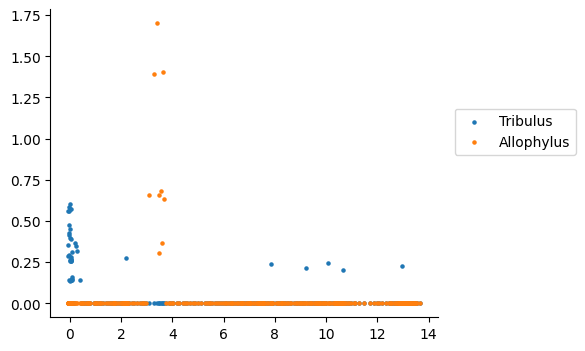

In [5]:
fig = plt.figure(figsize=(5,4))

vx = mydf['age']
myspecies = ['Tribulus', 'Allophylus']
for spec in myspecies:
    vy = mydf[spec]
    
    plt.scatter(vx, vy, label=spec, s=5)

ax = plt.gca()

ax.spines[['right', 'top']].set_visible(False)

#ax.set_yscale('log')
plt.legend(bbox_to_anchor=(1.025,0.7),loc='upper left')


# plt.savefig('plots-tests/basa_data-sel_species.pdf')
# plt.savefig('plots-tests/basa_data-sel_species.jpg')

plt.show()    

## Running GAM

In [142]:
species_grid = {} # dictionary with the IDs of the species (as they change across networks)
species_fit = {}

In [147]:
print('Computing GAM ....\n\n')

vx = gm.utils.make_2d(mydf['age'], verbose=False).astype('float')


for spec in myspecies:
    print('\tIterating on species %s ...' %(spec))

    vy = mydf[spec]
    
    mygam = gm.GAM(terms='auto', n_splines=100).fit(vx, vy)
    mygam = gm.GAM(terms='auto').gridsearch(vx, vy)

    XX = mygam.generate_X_grid(term=0, n=400)
    YY = mygam.predict(XX)
    

    species_grid[spec] = {}
    species_grid[spec]['prev_x'] = cp.copy(vx)
    species_grid[spec]['prev_y'] = cp.copy(vy)
    species_grid[spec]['x'] = cp.copy(XX)
    species_grid[spec]['y'] = cp.copy(YY)
    

print('Ho finito!')

  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--


Computing GAM ....


	Iterating on species Betula ...
	Iterating on species Pinus ...
	Iterating on species Corylus ...
	Iterating on species Artemisia ...


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


	Iterating on species Olea ...
Ho finito!


In [ ]:
import pyEDM as edm
import concurrent.futures
import time
import pickle

columns = 'Betula'
target = 'Artemisia'
species = species_fit.copy()

results = {}
def concurrent_CCM(columns, target, pair):

    #______________________________ Find the optimal embedding dimension ______________________________
    dfE = edm.EmbedDimension(dataFrame=pair, lib = [1, len(pair)], pred = [1, len(pair)],
                            columns=columns, target=target, showPlot=False)
    # dfE.plot('E', 'rho',figsize=(3,3))
    E = int(dfE.iloc[dfE['rho'].idxmax()]['E'])
    #________________________________________ Carry out CCM ___________________________________________

    result = edm.CCM(dataFrame=pair,\
                    columns = columns, target = target,\
                    E = E, Tp=0, libSizes =[E+2, len(pair), len(pair)/20],\
                    sample = 3, showPlot=False)
    print('Done with %s:%s' %(columns, target))
    return result

futures = {}
for i,columns in enumerate(myspecies):
    for j,target in enumerate(myspecies):
        if i <= j:  # The crucial condition: i must be less than j
            continue
        print('Computing %s:%s' %(columns, target))
        pair = pd.DataFrame({columns : species[columns]['y'], target : species[target]['y']}, index=species[columns]['x'][:,0])
        futures[columns+'-'+target] = concurrent_CCM(columns, target, pair)

    


Computing Pinus:Betula
Computing Corylus:Betula
Computing Corylus:Pinus
Computing Artemisia:Betula
Computing Artemisia:Pinus
Computing Artemisia:Corylus
Computing Olea:Betula
Computing Olea:Pinus
Computing Olea:Corylus
Computing Olea:Artemisia


Traceback (most recent call last):
  File "c:\Users\17498375K\AppData\Local\anaconda3\envs\new_python3_11\Lib\multiprocessing\queues.py", line 246, in _feed
    send_bytes(obj)
  File "c:\Users\17498375K\AppData\Local\anaconda3\envs\new_python3_11\Lib\multiprocessing\connection.py", line 184, in send_bytes
    self._check_closed()
  File "c:\Users\17498375K\AppData\Local\anaconda3\envs\new_python3_11\Lib\multiprocessing\connection.py", line 137, in _check_closed
    raise OSError("handle is closed")
OSError: handle is closed
Traceback (most recent call last):
  File "c:\Users\17498375K\AppData\Local\anaconda3\envs\new_python3_11\Lib\multiprocessing\queues.py", line 246, in _feed
    send_bytes(obj)
  File "c:\Users\17498375K\AppData\Local\anaconda3\envs\new_python3_11\Lib\multiprocessing\connection.py", line 184, in send_bytes
    self._check_closed()
  File "c:\Users\17498375K\AppData\Local\anaconda3\envs\new_python3_11\Lib\multiprocessing\connection.py", line 137, in _check_closed
  

In [174]:
for key in futures.keys():
    results[key] = futures[key].result()

In [187]:
conda install spyder-kernels=2.5

Retrieving notices: done
Channels:
 - defaults
 - conda-forge
Platform: win-64
Solving environment: ...working... done

## Package Plan ##

  environment location: c:\Users\17498375K\AppData\Local\anaconda3\envs\new_python3_11

  added / updated specs:
    - spyder-kernels=2.5


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    cloudpickle-3.0.0          |  py311haa95532_0          41 KB
    spyder-kernels-2.5.0       |  py311haa95532_0         204 KB
    ------------------------------------------------------------
                                           Total:         245 KB

The following NEW packages will be INSTALLED:

  cloudpickle        pkgs/main/win-64::cloudpickle-3.0.0-py311haa95532_0 
  spyder-kernels     pkgs/main/win-64::spyder-kernels-2.5.0-py311haa95532_0 



spyder-kernels-2.5.0 | 204 KB    |            |   0% 

cloudpickle-3.0.0    | 41 KB     |            |   0% 

clou

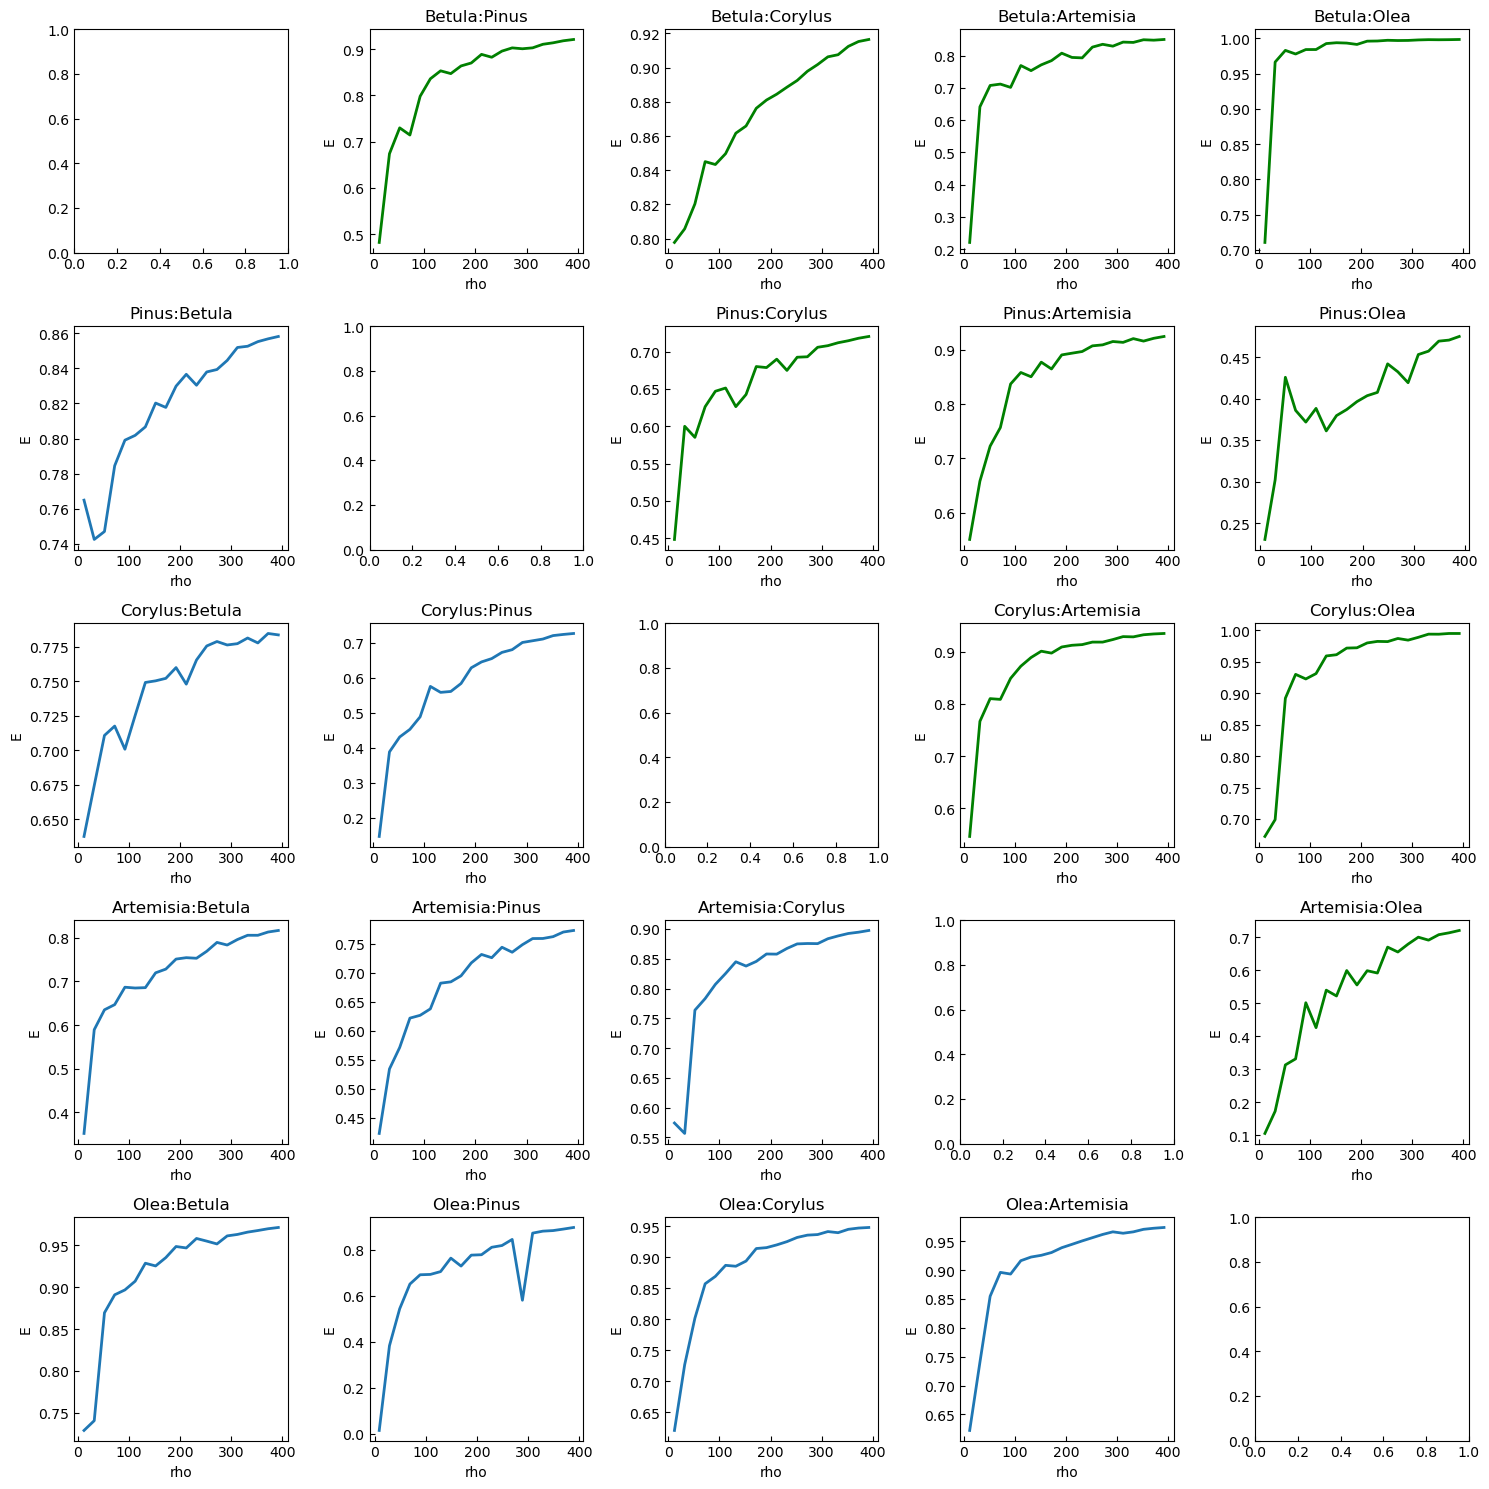

In [ ]:
# plot the results in a grid

fig, axs = plt.subplots(len(myspecies), len(myspecies), figsize=(15,15))

for i, columns in enumerate(myspecies):
    for j, target in enumerate(myspecies):
        if i <= j:  # The crucial condition: i must be less than j
            continue
        result = results[columns+'-'+target]
        axs[i,j].plot(result['LibSize'], result[columns+'-'+target], lw=2)
        axs[i,j].set_xlabel('rho')
        axs[i,j].set_ylabel('E')
        axs[i,j].set_title(columns+'-'+target)

        axs[j,i].plot(result['LibSize'], result[target+'-'+columns], lw=2, color='green')
        axs[j,i].set_xlabel('rho')
        axs[j,i].set_ylabel('E')
        axs[j,i].set_title(target+'-'+columns)

In [23]:
future.result()

,LibSize,Betula:Artemisia,Artemisia:Betula
0,12,0.57731,0.42031
1,52,0.68022,0.55866
2,92,0.76194,0.66654
3,132,0.79231,0.69169
4,172,0.78725,0.75492
5,212,0.81881,0.76032
6,252,0.81651,0.77141
7,292,0.84658,0.79239
8,332,0.83383,0.80576
9,372,0.84838,0.81513


	Iterating on species Betula ...


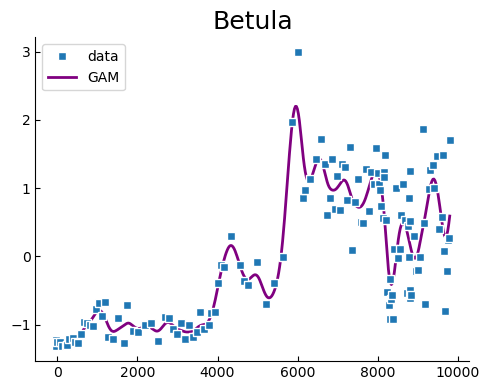

	Iterating on species Pinus ...


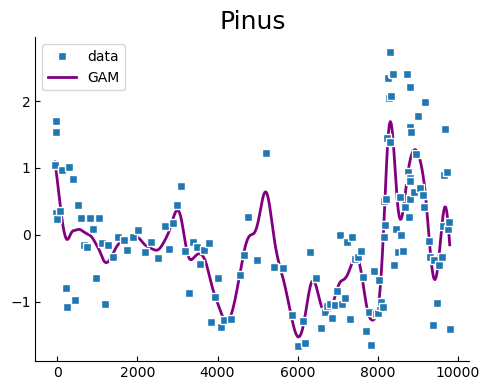

	Iterating on species Corylus ...


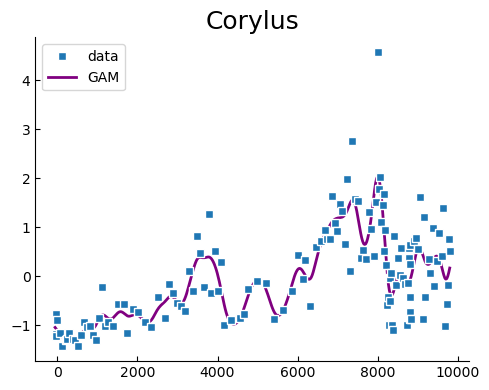

	Iterating on species Artemisia ...


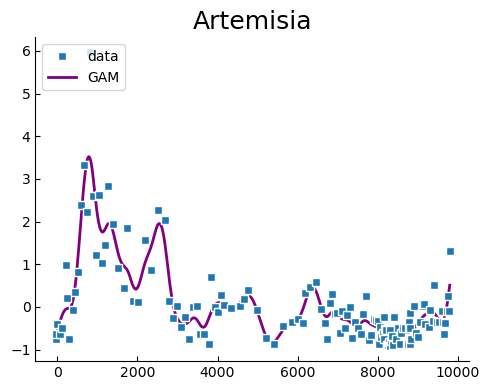

	Iterating on species Olea ...


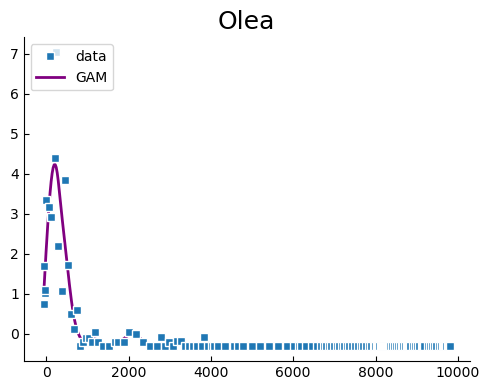

In [9]:
for spec in myspecies:
    print('\tIterating on species %s ...' %(spec))
    
    # data
    datx = species[spec]['vx']
    daty = species[spec]['vy']
    
    # GAM
    gamx = species[spec]['xx']
    gamy = species[spec]['yy']
    
    fig,ax = plt.subplots(figsize=(5,4))
    
    plt.plot(datx, daty, lw=0, marker='s', markeredgecolor='w', label='data', zorder=2)
    plt.plot(gamx, gamy, lw=2, ls='-', color='purple', label='GAM', zorder=1)
    
    ax.set_title(spec, fontsize=18)
    
    plt.legend(loc='upper left')
    ax.spines[['right', 'top']].set_visible(False)

    fignameout = 'basa_data-'+spec+'-gam_spline2'
    # fignameout = 'basa_data-'+spec+'-gam'
    
    plt.savefig('plots-tests/'+fignameout+'.pdf')
    plt.savefig('plots-tests/'+fignameout+'.jpg')
    
    plt.show()

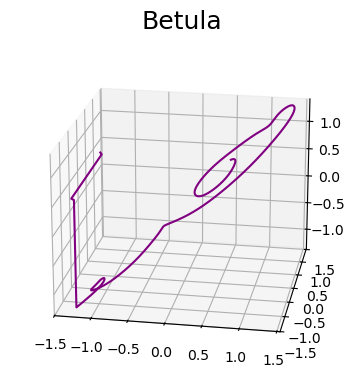

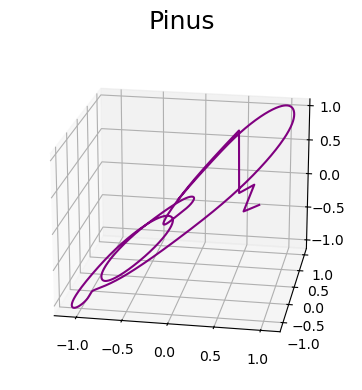

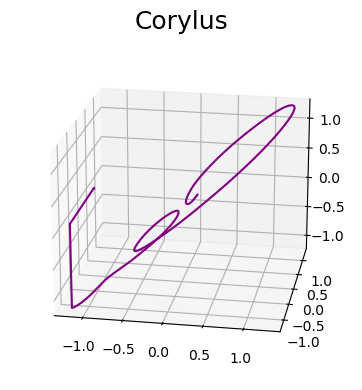

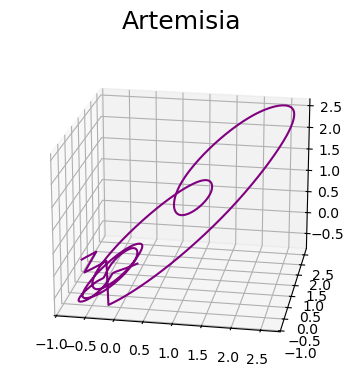

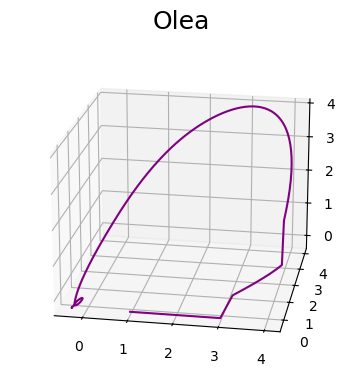

In [86]:
# draw the shadow manifold of the GAM of Artemisia
from mpl_toolkits import mplot3d

spec = 'Corylus'
for spec in myspecies:

    gamx = species[spec]['xx']
    gamy = species[spec]['yy']

    fig = plt.figure(figsize=(5,4))
    ax = plt.axes(projection='3d')
    ax.plot3D(gamy, np.roll(gamy, 20), np.roll(gamy, 40), 'purple')
    ax.set_title(spec, fontsize=18)
    ax.view_init(20, -80)

    ax.set_title(spec, fontsize=18)

    fignameout = 'basa_data-'+spec+'-gam_shadow'

    plt.savefig('manifolds_examples/'+fignameout+'.pdf')


In [ ]:
for i,columns in enumerate(myspecies):
        for j,target in enumerate(myspecies):
            if i <= j:  # The crucial condition: i must be less than j
                continue
            pair = pd.read_pickle('pair_files/pair_%s_%s.pkl' %(columns, target))

In [44]:
columns = 'Quercus caducifolio'
target = 'Abies'
pair = pd.read_pickle('pair_files/pair_%s_%s.pkl' %(columns, target))
pair


,Quercus caducifolio,Abies
-56.870000,0.053363,0.000468
-7.348040,0.053184,0.000533
42.173920,0.053014,0.000600
91.695879,0.052856,0.000669
141.217839,0.052711,0.000740
...,...,...
9599.912161,0.043881,0.000025
9649.434121,0.044110,0.000023
9698.956080,0.044357,0.000021
9748.478040,0.044620,0.000020
